In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import f1_score

import  numpy as np
from tqdm import notebook

# Loading DataSet

In [2]:
data_dir = './Assignment 5 Dataset'

img_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

#img_transforms = transforms.Compose([transforms.Resize([224, 224]),
#                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform = img_transforms)
test_data = datasets.ImageFolder(data_dir + '/test',  transform = img_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform = img_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


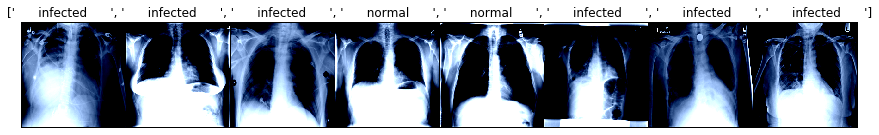

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=["      "+class_names[x]+"      " for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## Model Tunner

In [241]:
# Curves[0] = Loss Curve, Curves[1] = ValError Curve, Curves[2] = ValAcc Curve, Curves[3] = TrainAcc
# Curves = [[], [], [], []]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [262]:
def PrintBestAndWorst(Model):
    predictions = []
    probabilities = []
    ground_truth = []
    
    Model.to(device)
    
    best = [[0, None,0,0]]*2
    worst = [[0,None,0,0]]*2
    
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(testloader , leave=False, desc="Predicting ", mininterval=0.5 ) as TI:
            for data in TI:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = Model(images)
                probs, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                corMasked = probs * (predicted == labels).type(torch.cuda.FloatTensor)
                incorMasked = probs * (predicted != labels).type(torch.cuda.FloatTensor)
                
                if(torch.any(corMasked>0) and len(corMasked)>1):
                    ## Getting Best
                    maxI = corMasked.argmax().item()
                    if(maxI==0 and maxI+1 < labels.size(0)):
                        tempIs = (corMasked[maxI+1:].argmax().item() + maxI+1 , corMasked[maxI+1:].argmax().item() + maxI+1)
                    elif(maxI+1 < labels.size(0)):
                        tempIs = (corMasked[:maxI].argmax().item() , corMasked[maxI+1:].argmax().item() + maxI+1)
                    else:
                        tempIs = (corMasked[:maxI].argmax().item() , corMasked[:maxI].argmax().item())

                    secondMaxI = tempIs[0] if probs[tempIs[0]].item() > probs[tempIs[1]].item() else tempIs[1]
                    if(probs[maxI].item() > best[0][0]):
                        best[1] = best[0].copy()
                        best[0][0] = probs[maxI].item()
                        best[0][1] = images[maxI].clone()
                        best[0][2] = labels[maxI].item()
                        best[0][3] = predicted[maxI].item()
                        
                    if(probs[secondMaxI].item() > best[1][0]):
                        best[1][0] = probs[secondMaxI].item()
                        best[1][1] = images[secondMaxI].clone()
                        best[1][2] = labels[secondMaxI].item()
                        best[1][3] = predicted[secondMaxI].item()

                
                if(torch.any(incorMasked>0) and len(incorMasked) > 1):
                    ## Getting Worst
                    maxI = incorMasked.argmax().item()
                    
                    if(maxI==0 and maxI+1 < labels.size(0)):
                        tempIs = (incorMasked[maxI+1:].argmax().item() + maxI+1 , incorMasked[maxI+1:].argmax().item() + maxI+1)
                    elif(maxI+1 < labels.size(0)):
                        tempIs = (incorMasked[:maxI].argmax().item() , incorMasked[maxI+1:].argmax().item() + maxI+1)
                    else:
                        tempIs = (incorMasked[:maxI].argmax().item() , incorMasked[:maxI].argmax().item())

                    secondMaxI = tempIs[0] if probs[tempIs[0]].item() > probs[tempIs[1]].item() else tempIs[1]
                    if(probs[maxI].item() > worst[0][0]):
                        worst[1] = worst[0].copy()
                        
                        worst[0][0] = probs[maxI].item()
                        worst[0][1] = images[maxI].clone()
                        worst[0][2] = labels[maxI].item()
                        worst[0][3] = predicted[maxI].item()
                        
                    if(probs[secondMaxI].item() > worst[1][0] and labels[secondMaxI].item() != predicted[secondMaxI].item()):
                        worst[1][0] = probs[secondMaxI].item()
                        worst[1][1] = images[secondMaxI].clone()
                        worst[1][2] = labels[secondMaxI].item()
                        worst[1][3] = predicted[secondMaxI].item()


                predictions.append(predicted)
                probabilities.append(probs)
                ground_truth.append(labels)

                TI.set_postfix(Accuracy = (correct / total))
                
    P = torch.empty(4,3,224,224)
    P[0] = best[0][1]
    P[1] = best[1][1]
    P[2] = worst[0][1]
    P[3] = worst[1][1]

    out = torchvision.utils.make_grid(P)
    
    imshow(out,title=[[f"P={best[0][0]:.2f}, acutal={class_names[best[0][2]][:3]}, pred={class_names[best[0][3]][:3]}"],
                   [f"P={best[1][0]:.2f}, actual={class_names[best[1][2]][:3]}, pred={class_names[best[1][3]][:3]}"],
                   [f"P={worst[0][0]:.2f}, actual={class_names[worst[0][2]][:3]}, pred={class_names[worst[0][3]][:3]}"],
                   [f"P={worst[1][0]:.2f}, actual={class_names[worst[1][2]][:3]}, pred={class_names[worst[1][3]][:3]}"]] )
                
    return best, worst

In [260]:
def Train(Model, savePath, Epochs, Curves):
    
    Model.to(device)
    Model.train()

    for epoch in notebook.trange(Epochs):  # loop over the dataset multiple times

        train_correct = 0
        train_total = 0
        running_loss = 0.0
        
        with notebook.tqdm(trainloader , leave=False, desc="Training ", mininterval=0.5 ) as TI:
            for data in TI:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = Model(inputs)               #----> forward pass
                loss = criterion(outputs, labels)     #----> compute loss
                loss.backward()                       #----> backward pass
                optimizer.step()                      #----> weights update

                # print and saving statistics
                running_loss += loss.item()
                _ , predicted = torch.max(outputs.data, 1)
                
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                TI.set_postfix(Loss = (loss.data.item()))
                
        acc, _, __ = Accuracy(Model, valloader)
        
        print(f"Epoch {epoch+1}, Loss = {running_loss}, ValAcc = {acc}, ValError = {1-acc}")
        
        Curves[0].append(running_loss)
        Curves[1].append(1-acc)
        
        Curves[2].append(train_correct/train_total)
        Curves[3].append(acc)
        
        torch.save(Model.state_dict(), savePath)
    
    print('Finished Training')
    
def Accuracy(Model, dataLoader):
    
    Model.to(device)
    predictions = []
    ground_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(dataLoader , leave=False, desc="Predicting ", mininterval=0.5 ) as TI:
            for data in TI:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = Model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                predictions.append(predicted)
                ground_truth.append(labels)
                
                TI.set_postfix(Accuracy = (correct / total))
        
    return (correct / total), torch.cat(predictions), torch.cat(ground_truth)
    


In [249]:
#Taken From CV Assignment 4
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    print('Confusion Matrix')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def PlotCurves(Curves):
    
    ## Train Val Loss Curves
    plt.plot(np.arange(len(Curves[0])), np.array(Curves[0])/299, label="Training Avg Loss")
    plt.plot(np.arange(len(Curves[1])), Curves[1], label="Validation Error")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.title("Training and Validation Loss Curves.")
    plt.show()
    
    
    # Train Val Acc Curves
    plt.plot(np.arange(len(Curves[2])), Curves[2], label="Training Accuracy")
    plt.plot(np.arange(len(Curves[3])), Curves[3], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy Curves.")
    plt.show()


# Fine Tuning VGG-16

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Changing the Model's FC Layers

In [8]:
features = list(vgg16.classifier.children())[:-3] # Remove last 3 layers

features[0].out_features = (12*10)+100
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)

vgg16.classifier = nn.Sequential(*features)
print(vgg16)

[Linear(in_features=25088, out_features=220, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=220, out_features=2, bias=True)]

### VGG FC-Layers Tunning

Epoch 1, Loss = 15.174664855003357, ValAcc = 0.8709030100334448, ValError = 0.12909698996655516


Epoch 2, Loss = 13.825251698493958, ValAcc = 0.8675585284280937, ValError = 0.13244147157190633


Epoch 3, Loss = 13.369148850440979, ValAcc = 0.8474916387959867, ValError = 0.15250836120401334


Epoch 4, Loss = 11.374760150909424, ValAcc = 0.8515050167224081, ValError = 0.14849498327759192


Epoch 5, Loss = 11.979819416999817, ValAcc = 0.8521739130434782, ValError = 0.14782608695652177


Epoch 6, Loss = 10.848777055740356, ValAcc = 0.8454849498327759, ValError = 0.1545150501672241


Epoch 7, Loss = 10.953767895698547, ValAcc = 0.8535117056856187, ValError = 0.14648829431438126


Epoch 8, Loss = 11.07955276966095, ValAcc = 0.862876254180602, ValError = 0.137123745819398


Epoch 9, Loss = 9.31678581237793, ValAcc = 0.8695652173913043, ValError = 0.13043478260869568


Epoch 10, Loss = 9.209388971328735, ValAcc = 0.8508361204013378, ValError = 0.14916387959866217

Finished Training


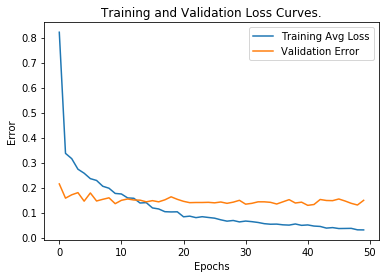

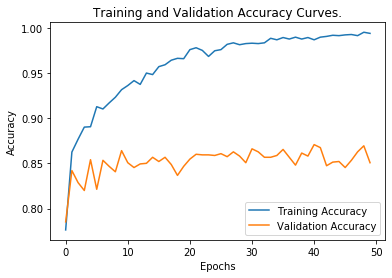

In [16]:
layers = 30     # layers to freeze in Convolutional Layers
# Freeze training for all layers
for param in vgg16.features[:layers+1].parameters():
    param.requires_grad = False

Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.00006, momentum=0.9)

#VGG_Curves = [[],[],[],[]]

Train(vgg16, "vgg16_FC_Only.pth", Epochs, VGG_Curves)
PlotCurves(VGG_Curves)


After FC Layers Fine Tunning the Accuracy is 92.01%
Confusion Matrix


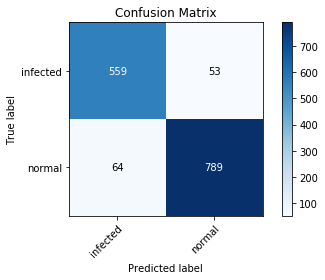

In [17]:
acc, predictions, grndTruth = Accuracy(vgg16, testloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 99.66%
Confusion Matrix


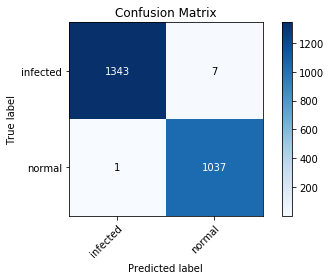

In [18]:
acc, predictions, grndTruth = Accuracy(vgg16, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 85.42%
Confusion Matrix


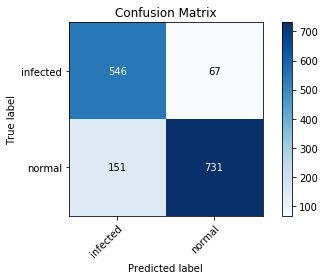

In [19]:
acc, predictions, grndTruth = Accuracy(vgg16, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
vgg16.to("cpu")

torch.cuda.empty_cache()

### VGG FC-Layers + Conv Layers Tunning

In [7]:
vgg16 = models.vgg16(pretrained=True)

features = list(vgg16.classifier.children())[:-3] # Remove last 3 layers

features[0].out_features = (12*10)+100
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)

vgg16.classifier = nn.Sequential(*features)
vgg16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Epoch 1, Loss = 209.57432514429092, ValAcc = 0.7705685618729097, ValError = 0.22943143812709033


Epoch 2, Loss = 84.88887143135071, ValAcc = 0.8327759197324415, ValError = 0.16722408026755853


Epoch 3, Loss = 66.38100951910019, ValAcc = 0.7979933110367893, ValError = 0.20200668896321072


Epoch 4, Loss = 54.342607259750366, ValAcc = 0.8608695652173913, ValError = 0.13913043478260867


Epoch 5, Loss = 47.390095591545105, ValAcc = 0.8802675585284281, ValError = 0.11973244147157192


Epoch 6, Loss = 40.36319863796234, ValAcc = 0.8822742474916387, ValError = 0.11772575250836126


Epoch 7, Loss = 33.40230333805084, ValAcc = 0.8842809364548495, ValError = 0.11571906354515049


Epoch 8, Loss = 27.800769567489624, ValAcc = 0.8735785953177257, ValError = 0.12642140468227425


Epoch 9, Loss = 23.369916558265686, ValAcc = 0.8862876254180602, ValError = 0.11371237458193983


Epoch 10, Loss = 22.874902606010437, ValAcc = 0.8976588628762542, ValError = 0.10234113712374582


Epoch 11, Loss = 13.84775960445404, ValAcc = 0.8755852842809364, ValError = 0.1244147157190636


Epoch 12, Loss = 14.540266752243042, ValAcc = 0.8896321070234113, ValError = 0.11036789297658867


Epoch 13, Loss = 10.927172780036926, ValAcc = 0.882943143812709, ValError = 0.117056856187291


Epoch 14, Loss = 7.957905173301697, ValAcc = 0.894314381270903, ValError = 0.10568561872909699


Epoch 15, Loss = 6.4687196016311646, ValAcc = 0.8889632107023412, ValError = 0.11103678929765881


Epoch 16, Loss = 5.765796422958374, ValAcc = 0.8949832775919733, ValError = 0.10501672240802673


Epoch 17, Loss = 3.181868553161621, ValAcc = 0.8849498327759198, ValError = 0.11505016722408024


Epoch 18, Loss = 3.206370711326599, ValAcc = 0.8816053511705686, ValError = 0.1183946488294314


Epoch 19, Loss = 2.8691357374191284, ValAcc = 0.8816053511705686, ValError = 0.1183946488294314


Epoch 20, Loss = 3.6737083196640015, ValAcc = 0.8722408026755852, ValError = 0.12775919732441476


Epoch 21, Loss = 3.8297102451324463, ValAcc = 0.894314381270903, ValError = 0.10568561872909699


Epoch 22, Loss = 2.8120511770248413, ValAcc = 0.8956521739130435, ValError = 0.10434782608695647


Epoch 23, Loss = 1.9660621881484985, ValAcc = 0.8896321070234113, ValError = 0.11036789297658867


Epoch 24, Loss = 1.2430702447891235, ValAcc = 0.8936454849498328, ValError = 0.10635451505016724


Epoch 25, Loss = 1.0908660888671875, ValAcc = 0.8903010033444816, ValError = 0.10969899665551841


Epoch 26, Loss = 0.6965526342391968, ValAcc = 0.8816053511705686, ValError = 0.1183946488294314


Epoch 27, Loss = 1.032408356666565, ValAcc = 0.8836120401337793, ValError = 0.11638795986622075


Epoch 28, Loss = 0.8541077375411987, ValAcc = 0.8775919732441472, ValError = 0.12240802675585283


Epoch 29, Loss = 0.7649799585342407, ValAcc = 0.8889632107023412, ValError = 0.11103678929765881


Epoch 30, Loss = 0.6921060085296631, ValAcc = 0.8876254180602007, ValError = 0.11237458193979932


Epoch 31, Loss = 1.1818509101867676, ValAcc = 0.894314381270903, ValError = 0.10568561872909699


Epoch 32, Loss = 0.6791332960128784, ValAcc = 0.8876254180602007, ValError = 0.11237458193979932


Epoch 33, Loss = 1.648654580116272, ValAcc = 0.8836120401337793, ValError = 0.11638795986622075


Epoch 34, Loss = 0.4223475456237793, ValAcc = 0.8836120401337793, ValError = 0.11638795986622075


Epoch 35, Loss = 0.4057281017303467, ValAcc = 0.882943143812709, ValError = 0.117056856187291


Epoch 36, Loss = 1.048788070678711, ValAcc = 0.8949832775919733, ValError = 0.10501672240802673


Epoch 37, Loss = 0.5774805545806885, ValAcc = 0.8836120401337793, ValError = 0.11638795986622075


Epoch 38, Loss = 0.3035017251968384, ValAcc = 0.8869565217391304, ValError = 0.11304347826086958


Epoch 39, Loss = 0.25746095180511475, ValAcc = 0.8949832775919733, ValError = 0.10501672240802673


Epoch 40, Loss = 0.3022336959838867, ValAcc = 0.8916387959866221, ValError = 0.1083612040133779


Epoch 41, Loss = 2.5008082389831543, ValAcc = 0.88561872909699, ValError = 0.11438127090300998


Epoch 42, Loss = 0.43693363666534424, ValAcc = 0.882943143812709, ValError = 0.117056856187291


Epoch 43, Loss = 0.4848484992980957, ValAcc = 0.8896321070234113, ValError = 0.11036789297658867


Epoch 44, Loss = 0.27947020530700684, ValAcc = 0.8923076923076924, ValError = 0.10769230769230764


Epoch 45, Loss = 0.21123123168945312, ValAcc = 0.8802675585284281, ValError = 0.11973244147157192


Epoch 46, Loss = 0.22396552562713623, ValAcc = 0.8869565217391304, ValError = 0.11304347826086958


Epoch 47, Loss = 0.29206860065460205, ValAcc = 0.8923076923076924, ValError = 0.10769230769230764


Epoch 48, Loss = 0.15431571006774902, ValAcc = 0.8876254180602007, ValError = 0.11237458193979932


Epoch 49, Loss = 0.340925931930542, ValAcc = 0.8802675585284281, ValError = 0.11973244147157192


Epoch 50, Loss = 0.2650761604309082, ValAcc = 0.8909698996655518, ValError = 0.10903010033444815

Finished Training


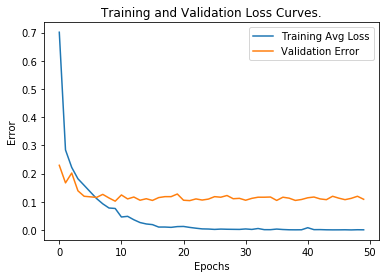

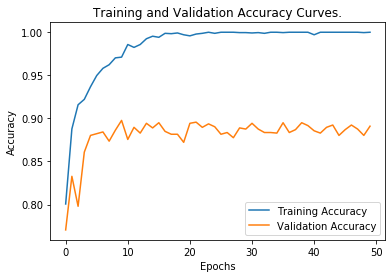

In [8]:
#layers = 29     # layers to freeze in Convolutional Layers

#for param in vgg16.features[:layers+1].parameters():
#    param.requires_grad = False

Epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.8)

VGG_Curves = [[],[],[],[]]

Train(vgg16, "vgg16_entire.pth", Epochs, VGG_Curves)
PlotCurves(VGG_Curves)


After FC Layers Fine Tunning the Accuracy is 95%
Confusion Matrix
F1 Score =  0.959387875220718


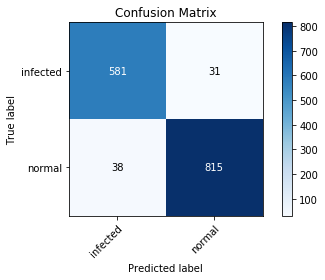

In [16]:
acc, predictions, grndTruth = Accuracy(vgg16, testloader)
print("After FC Layers Fine Tunning the Accuracy is %d%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))

vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 89.23%
Confusion Matrix


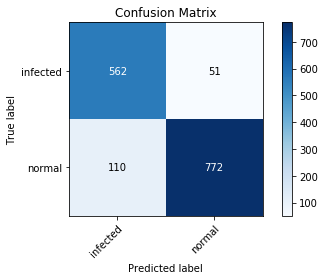

In [10]:
acc, predictions, grndTruth = Accuracy(vgg16, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 100.00%
Confusion Matrix


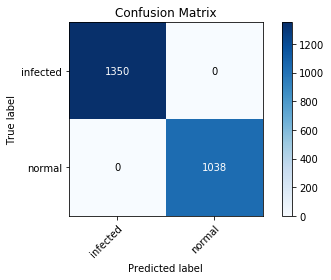

In [11]:
acc, predictions, grndTruth = Accuracy(vgg16, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
vgg16.to("cpu")

torch.cuda.empty_cache()

# Fine Tunning ResNet-18

### FC-Layer Tunning

In [11]:
resnet18 = models.resnet18(pretrained = True)

for param in resnet18.parameters():
    param.requires_grad = False
    
in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 220), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(220, len(class_names)))

resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Epoch 1, Loss = 194.4095076918602, ValAcc = 0.5933110367892976, ValError = 0.40668896321070236


Epoch 2, Loss = 162.9468071758747, ValAcc = 0.703010033444816, ValError = 0.29698996655518395


Epoch 3, Loss = 149.38471832871437, ValAcc = 0.7331103678929766, ValError = 0.26688963210702343


Epoch 4, Loss = 141.8341554403305, ValAcc = 0.7565217391304347, ValError = 0.24347826086956526


Epoch 5, Loss = 135.39776223897934, ValAcc = 0.7244147157190636, ValError = 0.2755852842809364


Epoch 6, Loss = 132.6810200214386, ValAcc = 0.7377926421404682, ValError = 0.26220735785953175


Epoch 7, Loss = 129.7988095730543, ValAcc = 0.7250836120401338, ValError = 0.27491638795986617


Epoch 8, Loss = 123.58580430597067, ValAcc = 0.7565217391304347, ValError = 0.24347826086956526


Epoch 9, Loss = 122.92224431782961, ValAcc = 0.7431438127090301, ValError = 0.25685618729096993


Epoch 10, Loss = 118.88417909294367, ValAcc = 0.7605351170568562, ValError = 0.23946488294314383


Epoch 11, Loss = 122.49401468038559, ValAcc = 0.7551839464882943, ValError = 0.24481605351170566


Epoch 12, Loss = 119.66260517388582, ValAcc = 0.7605351170568562, ValError = 0.23946488294314383


Epoch 13, Loss = 119.30741053074598, ValAcc = 0.7752508361204014, ValError = 0.22474916387959865


Epoch 14, Loss = 116.9529142305255, ValAcc = 0.7846153846153846, ValError = 0.2153846153846154


Epoch 15, Loss = 117.09982623159885, ValAcc = 0.7732441471571906, ValError = 0.2267558528428094


Epoch 16, Loss = 115.54193874448538, ValAcc = 0.7538461538461538, ValError = 0.24615384615384617


Epoch 17, Loss = 116.10050947219133, ValAcc = 0.768561872909699, ValError = 0.23143812709030098


Epoch 18, Loss = 117.03965049982071, ValAcc = 0.7752508361204014, ValError = 0.22474916387959865


Epoch 19, Loss = 111.39560430496931, ValAcc = 0.7765886287625418, ValError = 0.22341137123745824


Epoch 20, Loss = 114.50985891371965, ValAcc = 0.7732441471571906, ValError = 0.2267558528428094


Epoch 21, Loss = 117.75887294858694, ValAcc = 0.7745819397993311, ValError = 0.2254180602006689


Epoch 22, Loss = 111.41151069104671, ValAcc = 0.7933110367892977, ValError = 0.2066889632107023


Epoch 23, Loss = 114.06136048585176, ValAcc = 0.7806020066889632, ValError = 0.21939799331103682


Epoch 24, Loss = 110.90952877700329, ValAcc = 0.7866220735785954, ValError = 0.21337792642140463


Epoch 25, Loss = 108.42398147284985, ValAcc = 0.7839464882943143, ValError = 0.21605351170568565


Epoch 26, Loss = 107.20314309746027, ValAcc = 0.7464882943143812, ValError = 0.25351170568561876


Epoch 27, Loss = 110.54933046549559, ValAcc = 0.7852842809364549, ValError = 0.21471571906354514


Epoch 28, Loss = 106.37963996082544, ValAcc = 0.7698996655518394, ValError = 0.23010033444816058


Epoch 29, Loss = 105.48659619688988, ValAcc = 0.7799331103678929, ValError = 0.22006688963210708


Epoch 30, Loss = 103.18383335322142, ValAcc = 0.7632107023411371, ValError = 0.23678929765886292


Epoch 31, Loss = 106.4210642427206, ValAcc = 0.7832775919732441, ValError = 0.2167224080267559


Epoch 32, Loss = 102.73108221590519, ValAcc = 0.7779264214046823, ValError = 0.22207357859531773


Epoch 33, Loss = 103.34116549044847, ValAcc = 0.7899665551839465, ValError = 0.21003344481605346


Epoch 34, Loss = 104.37070046365261, ValAcc = 0.7832775919732441, ValError = 0.2167224080267559


Epoch 35, Loss = 104.21388109773397, ValAcc = 0.7739130434782608, ValError = 0.22608695652173916


Epoch 36, Loss = 105.68395245820284, ValAcc = 0.7471571906354515, ValError = 0.2528428093645485


Epoch 37, Loss = 110.83745344728231, ValAcc = 0.7799331103678929, ValError = 0.22006688963210708


Epoch 38, Loss = 106.65354134142399, ValAcc = 0.7812709030100334, ValError = 0.21872909698996656


Epoch 39, Loss = 99.19743871688843, ValAcc = 0.7892976588628763, ValError = 0.21070234113712372


Epoch 40, Loss = 101.06936466693878, ValAcc = 0.7919732441471572, ValError = 0.2080267558528428


Epoch 41, Loss = 106.78654244542122, ValAcc = 0.7719063545150502, ValError = 0.22809364548494981


Epoch 42, Loss = 104.09041524678469, ValAcc = 0.7979933110367893, ValError = 0.20200668896321072


Epoch 43, Loss = 100.99377094209194, ValAcc = 0.7732441471571906, ValError = 0.2267558528428094


Epoch 44, Loss = 101.9956200197339, ValAcc = 0.797324414715719, ValError = 0.20267558528428098


Epoch 45, Loss = 102.4201067648828, ValAcc = 0.7739130434782608, ValError = 0.22608695652173916


Epoch 46, Loss = 98.94994985312223, ValAcc = 0.7906354515050167, ValError = 0.20936454849498332


Epoch 47, Loss = 100.02854044735432, ValAcc = 0.7919732441471572, ValError = 0.2080267558528428


Epoch 48, Loss = 103.29457553476095, ValAcc = 0.7638795986622073, ValError = 0.23612040133779266


Epoch 49, Loss = 101.69404935836792, ValAcc = 0.7846153846153846, ValError = 0.2153846153846154


Epoch 50, Loss = 103.07712025940418, ValAcc = 0.7678929765886288, ValError = 0.23210702341137124

Finished Training


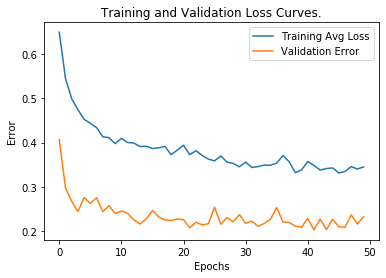

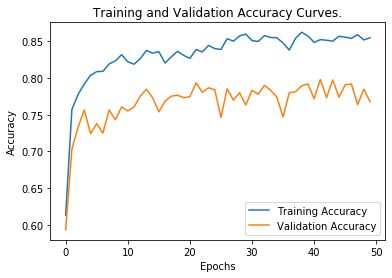

In [12]:
Epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

ResNet_Curves = [[],[],[],[]]

Train(resnet18, "resnet18_FC_Only.pth", Epochs, ResNet_Curves)
PlotCurves(ResNet_Curves)

After FC Layers Fine Tunning the Accuracy is 84.64%
Confusion Matrix


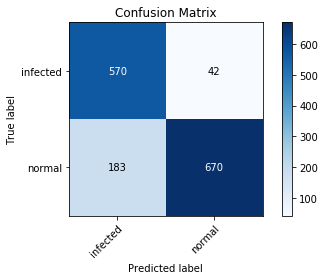

In [13]:
acc, predictions, grndTruth = Accuracy(resnet18, testloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 79.06%
Confusion Matrix


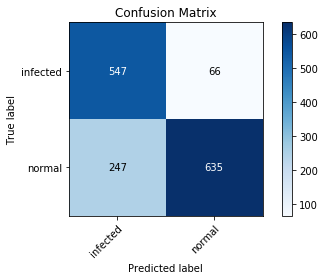

In [14]:
acc, predictions, grndTruth = Accuracy(resnet18, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 86.52%
Confusion Matrix


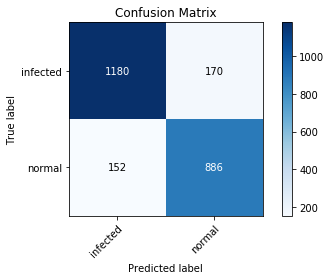

In [15]:
acc, predictions, grndTruth = Accuracy(resnet18, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

### Conv+FC_layer Tunning

In [17]:
resnet18 = models.resnet18(pretrained = True)

#for param in resnet18.parameters():
#    param.requires_grad = False
    
#for param in resnet18.layer4.parameters():
#    param.requires_grad = True
    
in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 220), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(220, len(class_names)))

resnet18


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Epoch 1, Loss = 136.23543773591518, ValAcc = 0.8267558528428094, ValError = 0.1732441471571906


Epoch 2, Loss = 90.42747192084789, ValAcc = 0.8173913043478261, ValError = 0.18260869565217386


Epoch 3, Loss = 82.4875415340066, ValAcc = 0.7719063545150502, ValError = 0.22809364548494981


Epoch 4, Loss = 62.21204061061144, ValAcc = 0.8521739130434782, ValError = 0.14782608695652177


Epoch 5, Loss = 56.01178362220526, ValAcc = 0.82876254180602, ValError = 0.17123745819397995


Epoch 6, Loss = 41.76467336714268, ValAcc = 0.7966555183946489, ValError = 0.20334448160535112


Epoch 7, Loss = 33.221300441771746, ValAcc = 0.8100334448160535, ValError = 0.18996655518394645


Epoch 8, Loss = 30.67124217003584, ValAcc = 0.8568561872909699, ValError = 0.1431438127090301


Epoch 9, Loss = 28.347351424396038, ValAcc = 0.8401337792642141, ValError = 0.15986622073578594


Epoch 10, Loss = 16.949929680675268, ValAcc = 0.8515050167224081, ValError = 0.14849498327759192


Epoch 11, Loss = 25.669408939778805, ValAcc = 0.8735785953177257, ValError = 0.12642140468227425


Epoch 12, Loss = 17.23493503034115, ValAcc = 0.8508361204013378, ValError = 0.14916387959866217


Epoch 13, Loss = 16.631803587079048, ValAcc = 0.8528428093645485, ValError = 0.14715719063545152


Epoch 14, Loss = 18.368667155504227, ValAcc = 0.8602006688963211, ValError = 0.13979933110367893


Epoch 15, Loss = 12.856197834014893, ValAcc = 0.8347826086956521, ValError = 0.16521739130434787


Epoch 16, Loss = 11.27808016166091, ValAcc = 0.8568561872909699, ValError = 0.1431438127090301


Epoch 17, Loss = 17.98197328299284, ValAcc = 0.854180602006689, ValError = 0.145819397993311


Epoch 18, Loss = 10.0317351706326, ValAcc = 0.8535117056856187, ValError = 0.14648829431438126


Epoch 19, Loss = 11.786999225616455, ValAcc = 0.8729096989966555, ValError = 0.1270903010033445


Epoch 20, Loss = 7.080763474106789, ValAcc = 0.8515050167224081, ValError = 0.14849498327759192


Epoch 21, Loss = 3.7831352204084396, ValAcc = 0.8675585284280937, ValError = 0.13244147157190633


Epoch 22, Loss = 4.744893155992031, ValAcc = 0.8481605351170568, ValError = 0.1518394648829432


Epoch 23, Loss = 9.433953642845154, ValAcc = 0.8494983277591973, ValError = 0.1505016722408027


Epoch 24, Loss = 9.182711467146873, ValAcc = 0.8729096989966555, ValError = 0.1270903010033445


Epoch 25, Loss = 4.261928595602512, ValAcc = 0.8555183946488294, ValError = 0.1444816053511706


Epoch 26, Loss = 10.16267940029502, ValAcc = 0.8555183946488294, ValError = 0.1444816053511706


Epoch 27, Loss = 4.919825945049524, ValAcc = 0.8635451505016722, ValError = 0.13645484949832776


Epoch 28, Loss = 4.618030749261379, ValAcc = 0.8622073578595317, ValError = 0.13779264214046827


Epoch 29, Loss = 8.569783736020327, ValAcc = 0.8581939799331104, ValError = 0.14180602006688958


Epoch 30, Loss = 4.799618776887655, ValAcc = 0.8722408026755852, ValError = 0.12775919732441476


Epoch 31, Loss = 4.728609561920166, ValAcc = 0.8816053511705686, ValError = 0.1183946488294314


Epoch 32, Loss = 11.204863365739584, ValAcc = 0.8448160535117056, ValError = 0.15518394648829437


Epoch 33, Loss = 4.079647485166788, ValAcc = 0.8528428093645485, ValError = 0.14715719063545152


Epoch 34, Loss = 3.5039703398942947, ValAcc = 0.8374581939799332, ValError = 0.16254180602006685


Epoch 35, Loss = 7.99795937538147, ValAcc = 0.8675585284280937, ValError = 0.13244147157190633


Epoch 36, Loss = 14.048852182924747, ValAcc = 0.8642140468227425, ValError = 0.1357859531772575


Epoch 37, Loss = 8.961601853370667, ValAcc = 0.8515050167224081, ValError = 0.14849498327759192


Epoch 38, Loss = 7.196910001337528, ValAcc = 0.8709030100334448, ValError = 0.12909698996655516


Epoch 39, Loss = 4.929032731801271, ValAcc = 0.8655518394648829, ValError = 0.1344481605351171


Epoch 40, Loss = 2.2878093980252743, ValAcc = 0.8749163879598663, ValError = 0.12508361204013374


Epoch 41, Loss = 2.960969030857086, ValAcc = 0.8775919732441472, ValError = 0.12240802675585283


Epoch 42, Loss = 4.037715204060078, ValAcc = 0.8729096989966555, ValError = 0.1270903010033445


Epoch 43, Loss = 1.9986753687262535, ValAcc = 0.8622073578595317, ValError = 0.13779264214046827


Epoch 44, Loss = 5.889952030032873, ValAcc = 0.8662207357859532, ValError = 0.13377926421404684


Epoch 45, Loss = 3.033667892217636, ValAcc = 0.8668896321070234, ValError = 0.1331103678929766


Epoch 46, Loss = 3.5050257071852684, ValAcc = 0.8662207357859532, ValError = 0.13377926421404684


Epoch 47, Loss = 2.07927368581295, ValAcc = 0.8709030100334448, ValError = 0.12909698996655516


Epoch 48, Loss = 6.506471645087004, ValAcc = 0.8702341137123746, ValError = 0.12976588628762542


Epoch 49, Loss = 10.338779713958502, ValAcc = 0.8816053511705686, ValError = 0.1183946488294314


Epoch 50, Loss = 2.771469045430422, ValAcc = 0.8642140468227425, ValError = 0.1357859531772575

Finished Training


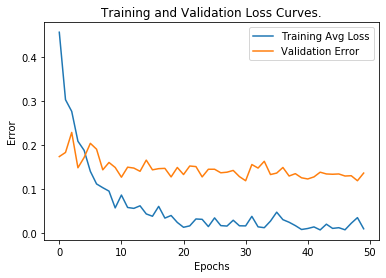

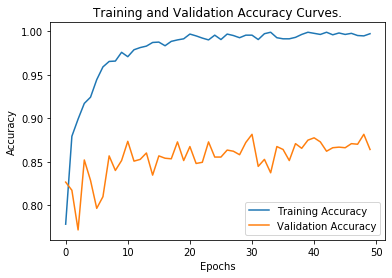

In [18]:
Epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.7)

ResNet_Curves = [[],[],[],[]]

Train(resnet18, "res18_entire.pth", Epochs, ResNet_Curves)
PlotCurves(ResNet_Curves)

After FC Layers Fine Tunning the Accuracy is 93.79%
Confusion Matrix
F1 Score =  0.945736434108527


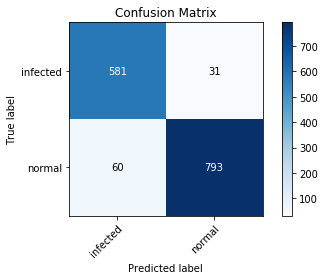

In [19]:
acc, predictions, grndTruth = Accuracy(resnet18, testloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 88.23%
Confusion Matrix
F1 Score =  0.8958579881656805


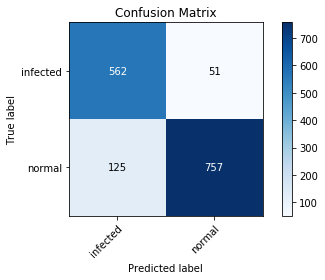

In [20]:
acc, predictions, grndTruth = Accuracy(resnet18, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 99.79%
Confusion Matrix
F1 Score =  0.9975973089860645


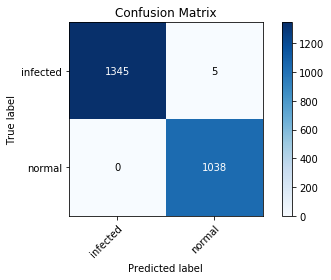

In [21]:
acc, predictions, grndTruth = Accuracy(resnet18, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu")))
resnet18.to("cpu")

torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


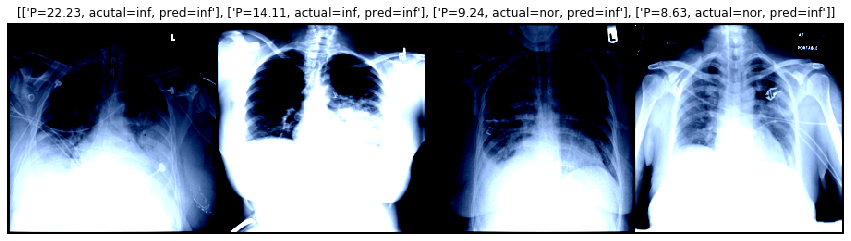

In [263]:
resnet18 = models.resnet18()

in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 220), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(220, len(class_names)))

resnet18.load_state_dict(torch.load("./TunedModels/res18_entire.pth"))
resnet18.to(device)
best, worst = PrintBestAndWorst(resnet18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


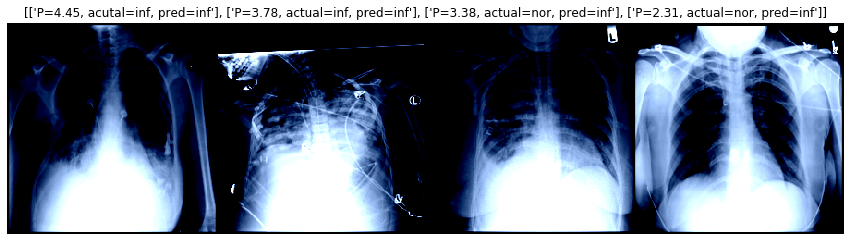

In [264]:
resnet18 = models.resnet18()

in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 220), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(220, len(class_names)))

resnet18.load_state_dict(torch.load("./TunedModels/resnet18_FC_Only.pth"))
resnet18.to(device)
best, worst = PrintBestAndWorst(resnet18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


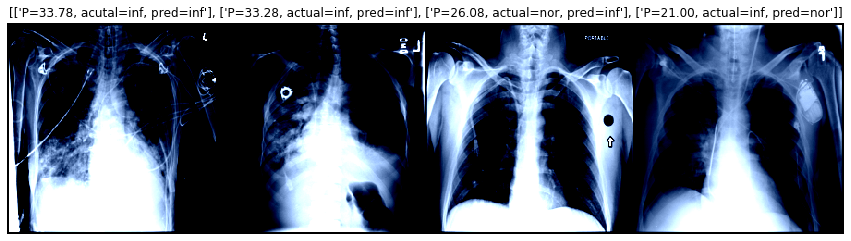

In [265]:
vgg16 = models.vgg16()

features = list(vgg16.classifier.children())[:-3] # Remove last 3 layers

features[0].out_features = (12*10)+100
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)

vgg16.classifier = nn.Sequential(*features)
vgg16.load_state_dict(torch.load("./TunedModels/vgg16_FC_Only.pth"))
best, worst = PrintBestAndWorst(vgg16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


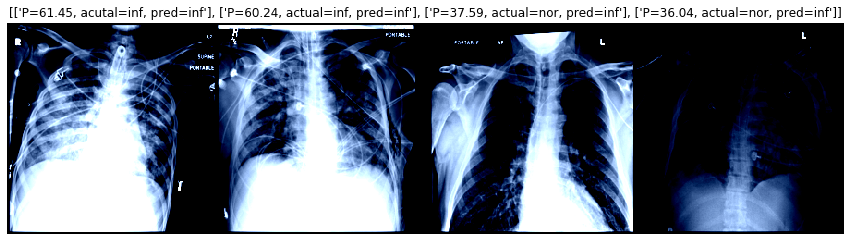

In [266]:
vgg16 = models.vgg16()

features = list(vgg16.classifier.children())[:-3] # Remove last 3 layers

features[0].out_features = (12*10)+100
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)

vgg16.classifier = nn.Sequential(*features)
vgg16.load_state_dict(torch.load("./TunedModels/vgg16_entire.pth"))
best, worst = PrintBestAndWorst(vgg16)